**Import Necessary libraries**

In [1]:
import os
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.filterwarnings('ignore')

**Data Preparation and Feature Selection**

In [2]:
df = pd.read_csv('cleaned_data_videoGames.csv')
df.head()

,Name,Platform,Year,Genre,Publisher,NA_ Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Rating,Total_Sales
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,76.0,8.0,E,82.74
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,82.0,8.3,E,35.83
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,80.0,8.0,E,33.00
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,89.0,8.5,E,30.01
4,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,58.0,6.6,E,29.01


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          1351 non-null   object 
 1   Platform      1351 non-null   object 
 2   Year          1351 non-null   int64  
 3   Genre         1351 non-null   object 
 4   Publisher     1351 non-null   object 
 5   NA_ Sales     1351 non-null   float64
 6   EU_Sales      1351 non-null   float64
 7   JP_Sales      1351 non-null   float64
 8   Other_Sales   1351 non-null   float64
 9   Global_Sales  1351 non-null   float64
 10  Critic_Score  1351 non-null   float64
 11  User_Score    1351 non-null   float64
 12  Rating        1350 non-null   object 
 13  Total_Sales   1351 non-null   float64
dtypes: float64(8), int64(1), object(5)
memory usage: 147.9+ KB


In [4]:
# Check for missing data
print(df.isnull().sum())


Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_ Sales       0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
Critic_Score    0
User_Score      0
Rating          1
Total_Sales     0
dtype: int64


**Feature Engineering**

In [5]:
# Creating a new feature "Total_Critic_Score" by adding Critic_Score and User_Score
df['Total_Critic_Score'] = df['Critic_Score'] + df['User_Score']

# Creating a new feature "Sales_Per_Year" by dividing Global_Sales by Year
df['Sales_Per_Year'] = df['Global_Sales'] / df['Year']


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Platform_Encoded']=le.fit_transform(df['Platform'])
df['Genre_Encoded'] = le.fit_transform(df['Genre'])
df['Rating_Encoded'] = le.fit_transform(df['Rating'])

In [7]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_ Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Rating,Total_Sales,Total_Critic_Score,Sales_Per_Year,Platform_Encoded,Genre_Encoded,Rating_Encoded
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,76.0,8.0,E,82.74,84.0,0.041246,14,10,0
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,82.0,8.3,E,35.83,90.3,0.017839,14,6,0
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,80.0,8.0,E,33.00,88.0,0.016426,14,10,0
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,89.0,8.5,E,30.01,97.5,0.014960,2,4,0
4,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,58.0,6.6,E,29.01,64.6,0.014467,14,3,0


In [8]:
# Using StandardScaler to scale the numerical feature "Global_Sales"
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['Global_Sales_Scaled'] = scaler.fit_transform(df[['Global_Sales']])


In [9]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_ Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Rating,Total_Sales,Total_Critic_Score,Sales_Per_Year,Platform_Encoded,Genre_Encoded,Rating_Encoded,Global_Sales_Scaled
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,76.0,8.0,E,82.74,84.0,0.041246,14,10,0,21.280205
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,82.0,8.3,E,35.83,90.3,0.017839,14,6,0,8.796565
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,80.0,8.0,E,33.00,88.0,0.016426,14,10,0,8.046269
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,89.0,8.5,E,30.01,97.5,0.014960,2,4,0,7.250743
4,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,58.0,6.6,E,29.01,64.6,0.014467,14,3,0,6.987342


I'm going  to perform a time series decomposition, and an auto correlation analysis to fit a SARIMA model for forecasting. This evaluates using RMSE as this will be the primary evaluation method for my models.

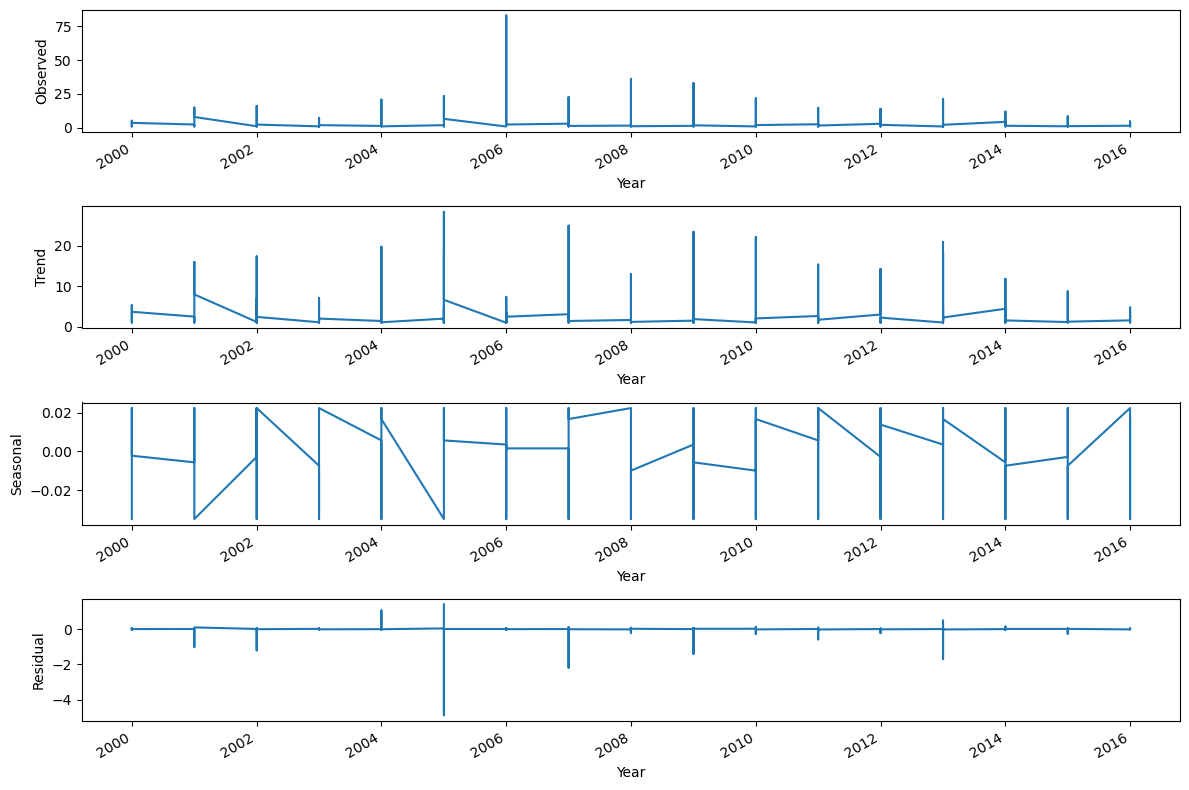

In [10]:

df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df = df.set_index("Year")

# Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df["Global_Sales"], model="additive", period=12)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel("Observed")
decomposition.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel("Trend")
decomposition.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel("Seasonal")
decomposition.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel("Residual")
plt.tight_layout()



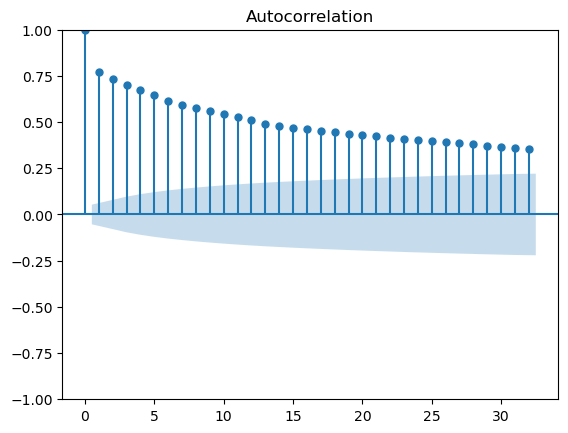

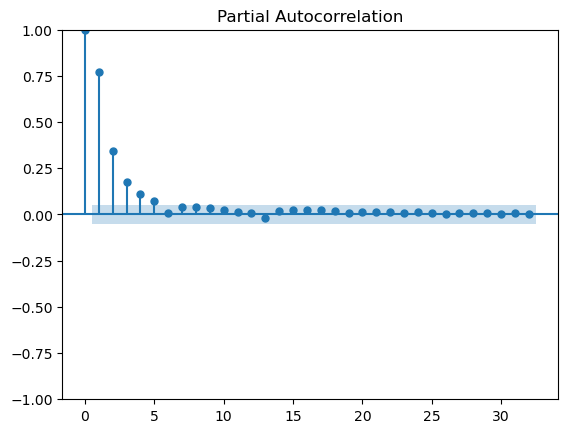

In [11]:
# Autocorrelation analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df["Global_Sales"])
plt.show()

plot_pacf(df["Global_Sales"])
plt.show()


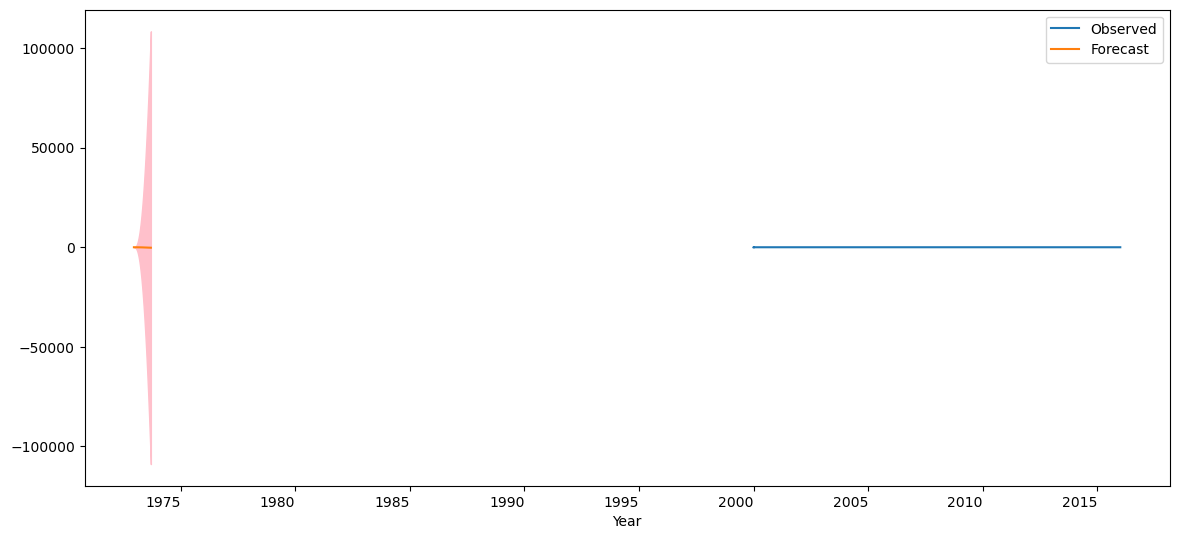

In [12]:
# Split the data into training and testing sets
train = df[:int(0.8 * len(df))]
test = df[int(0.8 * len(df)):]

# Fit the SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

sarima_model = SARIMAX(train["Global_Sales"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Forecasting
forecast = sarima_fit.get_forecast(steps=len(test))
forecast_confidence_interval = forecast.conf_int()

# Model Evaluation
test["Global_Sales"].plot(label="Observed")
forecast.predicted_mean.plot(label="Forecast", figsize=(14, 7))
plt.fill_between(forecast_confidence_interval.index,
                 forecast_confidence_interval.iloc[:, 0],
                 forecast_confidence_interval.iloc[:, 1], color='pink')
plt.legend()
plt.show()


In [13]:

# Calculate RMSE
rmse = sqrt(mean_squared_error(test["Global_Sales"], forecast.predicted_mean))
print('RMSE:', rmse)

RMSE: 111.78724058336554


**Applying the Machine Learning models:**

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve

In [15]:
# Prepare the dataset
df_clean = df.drop(columns=['Name', 'Rating'])  # Drop unnecessary columns
df_dummies = pd.get_dummies(df_clean, columns=['Genre', 'Platform', 'Publisher'])

# Define features (X) and target variable (y)
X = df_dummies.drop('Global_Sales', axis=1)  # Drop the target variable
y = df_dummies['Global_Sales']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Linear Regression**

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train the linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Make predictions
y_pred = linreg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Squared Error: 0.05304434995923028
R-squared: 0.9868073650691855


In [32]:
cv_scores_lr_test = cv_scores_test.mean()
cv_scores_lr_train = cv_scores_train.mean()
cv_scores_std_test_lr = cv_scores_test.std()

print('Mean cross-validation test score:', cv_scores_lr_test)
print('Mean cross-validation train score:', cv_scores_lr_train)
print('Standard deviation in cross-validation test scores:', cv_scores_std_test_lr)

Mean cross-validation test score: 0.9873239243321719
Mean cross-validation train score: 0.9304758857356561
Standard deviation in cross-validation test scores: 0.009300897053321175


**Support Vector Machine**

In [26]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)

# Predict using the model
y_predict_svr = svr.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import mean_squared_error

mse_svr = mean_squared_error(y_test, y_predict_svr)
print('Mean Squared Error for SVR:', mse_svr)

from sklearn.metrics import r2_score

r2_svr = r2_score(y_test, y_predict_svr)
print('R-squared for SVR:', r2_svr)


Mean Squared Error for SVR: 2.466909808860618
R-squared for SVR: 0.3864560402652205


In [27]:
cv_scores_test = cross_val_score(svr, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
cv_scores_train = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation for cross-validation scores
cv_scores_svr_test = cv_scores_test.mean()
cv_scores_svr_train = cv_scores_train.mean()
cv_scores_std_test_svr = cv_scores_test.std()

print('Mean cross-validation test score:', cv_scores_svr_test)
print('Mean cross-validation train score:', cv_scores_svr_train)
print('Standard deviation in cross-validation test scores:', cv_scores_std_test_svr)

Mean cross-validation test score: -3.8240974019186096
Mean cross-validation train score: -12.779116896592333
Standard deviation in cross-validation test scores: 1.2993464495301428


**Random Forest**

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Random Forest Regressor with Grid Search and Cross Validation
rf = RandomForestRegressor()

# Hyperparameters to search over
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object with the specified hyperparameters
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

# Get the best random forest model from the grid search
rf = grid_search.best_estimator_

# Feature Importance
feature_importances = pd.Series(rf.feature_importances_, index=pd.DataFrame(X_train).columns)
feature_importances.sort_values(ascending=False, inplace=True)
print(feature_importances)

# Model Evaluation
y_pred = rf.predict(X_test)

# Calculate mean squared error
mse_rf = mean_squared_error(y_test, y_pred)
print('Mean Squared Error for Random Forest:', mse_rf)

# Calculate R-squared
r2_rf = r2_score(y_test, y_pred)
print('R-squared for Random Forest:', r2_rf)


12    0.300508
6     0.292223
8     0.285057
0     0.047548
1     0.045960
        ...   
71    0.000000
76    0.000000
94    0.000000
60    0.000000
48    0.000000
Length: 101, dtype: float64
Mean Squared Error for Random Forest: 0.002039394212546326
R-squared for Random Forest: 0.9994927832399337


In [28]:
cv_scores_test = cross_val_score(rf, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
cv_scores_train = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(cv_scores_test)
cv_scores_rf_test = cv_scores_test.mean()
cv_scores_rf_train = cv_scores_train.mean()
cv_scores_std_rf = cv_scores_test.std()
print('Mean cross validation test score:', cv_scores_rf_test)
print('Mean cross validation train score:', cv_scores_rf_train)
print('Standard deviation in cv scores:', cv_scores_std_rf)

[-0.01057409 -0.00224947 -0.05909253 -0.06029251 -0.00382116]
Mean cross validation test score: -0.027205950304241923
Mean cross validation train score: -2.3444332108859296
Standard deviation in cv scores: 0.02667496053512971


**Gradient Boosting**

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

gbr = GradientBoostingRegressor(subsample=0.8, learning_rate=0.05, n_estimators=160, random_state=5, max_depth=9, max_leaf_nodes=100)
gbr.fit(X_train, y_train)

# Predict using the model
y_pred_gbr = gbr.predict(X_test)

# Calculate mean squared error
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print('Mean Squared Error for Gradient Boosting Regressor:', mse_gbr)

# Calculate R-squared
r2_gbr = r2_score(y_test, y_pred_gbr)
print('R-squared for Gradient Boosting Regressor:', r2_gbr)

Mean Squared Error for Gradient Boosting Regressor: 0.0019149379576947712
R-squared for Gradient Boosting Regressor: 0.9995237366956058


In [24]:
# Cross validation scores
cv_scores_test = cross_val_score(gbr, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
cv_scores_train = cross_val_score(gbr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation for cross-validation scores
cv_scores_gbr_test = cv_scores_test.mean()
cv_scores_gbr_train = cv_scores_train.mean()
cv_scores_std_gbr = cv_scores_test.std()

print('Mean cross-validation test score:', cv_scores_gbr_test)
print('Mean cross-validation train score:', cv_scores_gbr_train)
print('Standard deviation in cross-validation scores:', cv_scores_std_gbr)

Mean cross-validation test score: -0.020893056046421304
Mean cross-validation train score: -2.2327182749612455
Standard deviation in cross-validation scores: 0.013960535535220817


**Decision Tree**

In [29]:
from sklearn.tree import DecisionTreeRegressor

# Create a Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state=42)

# Fit the model to the training data
dt_reg.fit(X_train, y_train)

# Make predictions using the test data
y_pred = dt_reg.predict(X_test)

# Calculate mean squared error
mse_dt = mean_squared_error(y_test, y_pred)
print('Mean Squared Error for Decision Tree Regressor:', mse_dt)

# Calculate R-squared
r2_dt = r2_score(y_test, y_pred)
print('R-squared for Decision Tree Regressor:', r2_dt)

Mean Squared Error for Decision Tree Regressor: 0.00966420664206642
R-squared for Decision Tree Regressor: 0.997596419784148


In [30]:
# Cross-validation
cv_scores_test = cross_val_score(dt_reg, X_test, y_test, cv=5, scoring='r2')
cv_scores_train = cross_val_score(dt_reg, X_train, y_train, cv=5, scoring='r2')
print(cv_scores_test)
cv_scores_dt_test = cv_scores_test.mean()
cv_scores_dt_train = cv_scores_train.mean()
cv_scores_std_dt = cv_scores_test.std()
print('Mean cross validation test score:', cv_scores_dt_test)
print('Mean cross validation train score:', cv_scores_dt_train)
print('Standard deviation in cv scores:', cv_scores_std_dt)

[0.99580285 0.97521464 0.99052804 0.97744623 0.99762787]
Mean cross validation test score: 0.9873239243321719
Mean cross validation train score: 0.9304758857356561
Standard deviation in cv scores: 0.009300897053321175


**Comparison of the Models**

In [36]:
myLabels = ['Linear Regression', 'SVR', 'Random Forest', 'Gradient Boost', 'Decision Tree Regressor']

mse_scores = [mse, mse_svr, mse_rf, mse_gbr, mse_dt]
r2_scores = [r2, r2_svr, r2_rf, r2_gbr, r2_dt]

score_test = [cv_scores_lr_test, cv_scores_svr_test, cv_scores_rf_test, cv_scores_gbr_test, cv_scores_dt_test]
score_train = [cv_scores_lr_train, cv_scores_svr_train, cv_scores_rf_train, cv_scores_gbr_train, cv_scores_dt_train]

mse_tab = pd.DataFrame(list(zip(myLabels, mse_scores)),
                       columns=['Algorithm', 'Mean Squared Error'])

r2_tab = pd.DataFrame(list(zip(myLabels, r2_scores)),
                      columns=['Algorithm', 'R-squared'])

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)),
                         columns=['Algorithm', 'Cross Validation R-squared train score', 'Cross Validation R-squared test score'])

print(mse_tab)
print(r2_tab)
print(score_tab)


                 Algorithm  Mean Squared Error
0        Linear Regression            0.053044
1                      SVR            2.466910
2            Random Forest            0.002039
3           Gradient Boost            0.001915
4  Decision Tree Regressor            0.009664
                 Algorithm  R-squared
0        Linear Regression   0.986807
1                      SVR   0.386456
2            Random Forest   0.999493
3           Gradient Boost   0.999524
4  Decision Tree Regressor   0.997596
                 Algorithm  Cross Validation R-squared train score  \
0        Linear Regression                                0.930476   
1                      SVR                              -12.779117   
2            Random Forest                               -2.344433   
3           Gradient Boost                               -2.232718   
4  Decision Tree Regressor                                0.930476   

   Cross Validation R-squared test score  
0                         

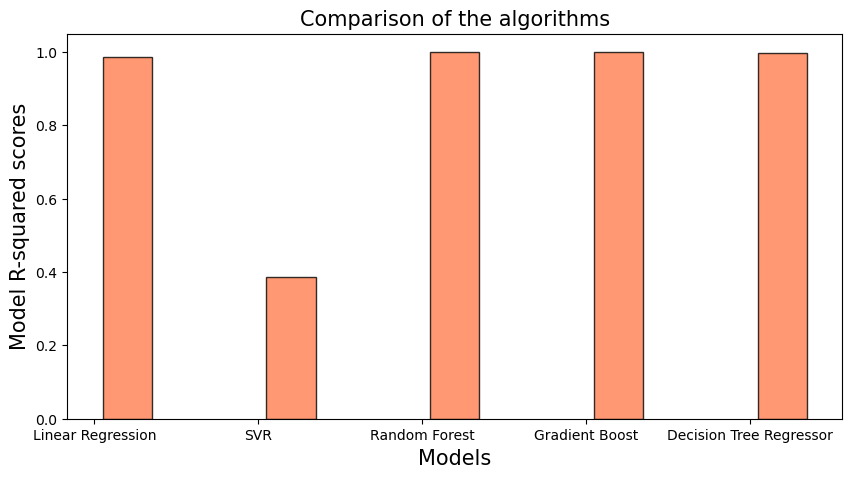

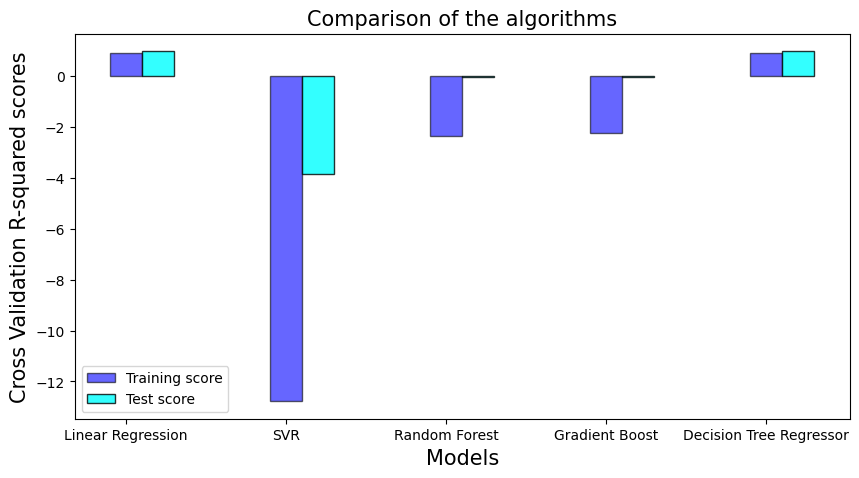

In [40]:
index = [1, 2, 3, 4, 5]
index_acc = [1.2, 2.2, 3.2, 4.2, 5.2]
plt.figure(figsize=(10, 5))
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model R-squared scores', fontsize=15)
plt.title('Comparison of the algorithms', fontsize=15)
_ = plt.bar(index_acc, r2_scores, color='coral', alpha=0.8, label='R-squared score', edgecolor='k', width=0.3)
plt.xticks([1, 2, 3, 4, 5], myLabels)
#plt.legend()
plt.savefig("26.png")
plt.show()

index = [1, 2, 3, 4, 5]
index_acc = [1.2, 2.2, 3.2, 4.2, 5.2]
plt.figure(figsize=(10, 5))
plt.xlabel('Models', fontsize=15)
plt.ylabel('Cross Validation R-squared scores', fontsize=15)
plt.title('Comparison of the algorithms', fontsize=15)
_ = plt.bar(index, score_train, color='b', alpha=0.6, label='Training score', edgecolor='k', width=0.2)
_ = plt.bar(index_acc, score_test, color='cyan', alpha=0.8, label='Test score', edgecolor='k', width=0.2)
plt.xticks([1, 2, 3, 4, 5], myLabels)
plt.legend()
plt.savefig("27.png")
plt.show()


**Fitting the Linear Regression Models with Lasso Ridge and ElasticNet with the optimal hyperparameters:**

In [41]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV

# Lasso Regression
lasso = Lasso()
lasso_params = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso, lasso_params, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train, y_train)
lasso_best = lasso_grid.best_estimator_


In [42]:

# Ridge Regression
ridge = Ridge()
ridge_params = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, scoring='neg_mean_squared_error', cv=5)
ridge_grid.fit(X_train, y_train)
ridge_best = ridge_grid.best_estimator_


In [43]:
# Elastic Net
elastic_net = ElasticNet()
elastic_net_params = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
                      'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
elastic_net_grid = GridSearchCV(elastic_net, elastic_net_params, scoring='neg_mean_squared_error', cv=5)
elastic_net_grid.fit(X_train, y_train)
elastic_net_best = elastic_net_grid.best_estimator_

In [44]:
coefs = lasso_best.coef_

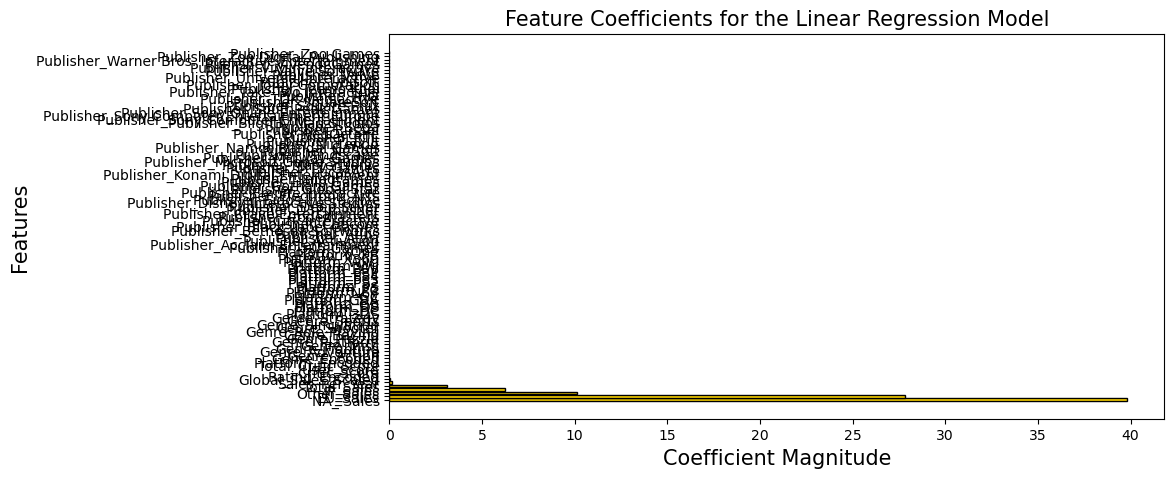

In [45]:
sorted_coefs = sorted(zip(X.columns, coefs), key=lambda x: abs(x[1]), reverse=True)

# Visualize the coefficients
plt.figure(figsize=(10, 5))
plt.barh([x[0] for x in sorted_coefs], [abs(x[1]) for x in sorted_coefs], align='center', color='gold', edgecolor='k')
plt.xlabel('Coefficient Magnitude', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title('Feature Coefficients for the Linear Regression Model', fontsize=15)
plt.savefig("coefs.png")
plt.show()

Linear Regression Model for Entire data set

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Instantiate the Linear Regression model
lr_final = LinearRegression()

# Train the model on the entire dataset
lr_final.fit(X, y)

# Make predictions on the test data
test_data_predictions = lr_final.predict(X_test)

# Calculate the Mean Squared Error and R-squared for the predictions
mse_final = mean_squared_error(y_test, test_data_predictions)
r2_final = r2_score(y_test, test_data_predictions)

# Print the final model metrics
print("Mean Squared Error (MSE):", mse_final)
print("R-squared (R2):", r2_final)


Mean Squared Error (MSE): 3.8303898939787038
R-squared (R2): 0.047345559842249085


In [50]:
# Get the coefficients and the intercept of the Linear Regression model
coefficients = lr_final.coef_
intercept = lr_final.intercept_

# Print the coefficients and the intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [ 1.89527010e-13  1.73083770e-13  1.83575377e-13  1.81410442e-13
  1.40399466e-01  1.40399466e-01 -2.32994180e-13 -1.40399466e-01
 -6.17883800e-11 -1.91777853e-04  1.79099488e-03 -1.94289029e-16
  3.75851919e+00  1.05713335e-02  8.78033867e-03  6.98934379e-03
  5.19834891e-03  3.40735403e-03  1.61635915e-03 -1.74635734e-04
 -1.96563061e-03 -3.75662549e-03 -5.54762037e-03 -7.33861526e-03
 -9.12961014e-03 -8.08606349e-04 -6.16828496e-04 -4.25050643e-04
 -2.33272789e-04 -4.14949364e-05  1.50282917e-04  3.42060770e-04
  5.33838623e-04  7.25616476e-04  9.17394329e-04  1.10917218e-03
  1.30095004e-03  1.49272789e-03  1.68450574e-03  1.87628359e-03
  2.06806145e-03  2.25983930e-03  2.45161715e-03  2.64339501e-03
  2.55529676e-04  2.55529676e-04  2.55529676e-04  2.55529676e-04
  2.55529676e-04  2.55529676e-04  2.55529676e-04  2.55529676e-04
  2.55529676e-04  2.55529676e-04  2.55529676e-04  2.55529676e-04
  2.55529676e-04  2.55529676e-04  2.55529676e-04  2.55529676e-04
  2.5552967

**Conclusion**

I am deciding to choose Linear Regression as the model as it has a number of factors that led me to this decision. Model Simplicity, Linear Regression is a simpler model and it performs as well if not better than all of the other models, it is easier to interpret. The cross validation gives a good representation of unseen data and with the model being positive it would be a better choice.